![title](https://uploads-ssl.webflow.com/60bf980093a9f42751201f48/629124f350af2e9f741cc496_name_yellow-removebg-preview.png)
<hr>


# Introduction to the project

**<font size="5">Starting a Machine Learning Project on QuantConnect based on Bitcoin price forecasting</font>**
<font size="3"><font>

The following summarizes some of my experience working on a forecasting problem using Machine Learning (ML) with QuantConnect (QC). To date, QC has had some updates so some of the experience could not apply anymore, but It could in other projects with similar issues.

**<font size="5">Forecasting Problem</font>**


The objective of this project case was to develop a forecasting model that uses only historical data prices. Usually, for this process, you could make much more feature engineering, but for the time being, the idea is to keep that part of the process simple. In this blog, we will focus on two main steps, the Machine Learning Framework where we will see a practical example of Custom Datasets from PyTorch applied to a DataFrame. Following, Transfer learning will save us a lot of time in training and will give us a starting point for our project. This project use hour data from the bitcoin (BTC) prices to create a forecasting model.



# Some useful libraries

In [1]:
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from pywt import cwt

import seaborn as sns
import pandas as pd
import numpy as np

import requests
import warnings
import ssl # A 
ssl._create_default_https_context = ssl._create_unverified_context

torch.__version__

'1.12.0'

# Get the data and clean it

<font size="3"><font>

For the data acquisition, we will use the [Crypto Data Download](https://www.cryptodatadownload.com/) page that daily updates a CSV with the Bitcoin and the United States dollar exchange rate (BTCUSD).Note, pay special attention to the data passed to the dataset object so you can modify it according to your needs.

In [2]:
def get_btcusd_data():
  url_data = requests.get('https://www.cryptodatadownload.com/cdd/Bitfinex_BTCUSD_1h.csv')
  data = pd.DataFrame(map(lambda x: x.split(','),url_data.text.splitlines()[2:]),columns=url_data.text.splitlines()[1].split(','))
  for c in data.columns:
      if not c in ['date','symbol']:
        data[c] = pd.to_numeric(data[c])
  data['date']  = pd.to_datetime(data['date'])
  data = data.iloc[::-1]
  data = data.set_index('date',drop=False)
  data = data[~data.index.duplicated()]
  return data.resample('H').ffill()#.index.to_timedelta()
get_btcusd_data()

,unix,date,symbol,open,high,low,close,Volume USD,Volume BTC
date,,,,,,,,,
2018-05-15 06:00:00,1526364000,2018-05-15 06:00:00,BTC/USD,8723.8,8793.0,8714.900000,8739.000000,8.988054e+06,1026.350000
2018-05-15 07:00:00,1526367600,2018-05-15 07:00:00,BTC/USD,8739.0,8754.8,8719.300000,8743.000000,2.288904e+06,261.970000
2018-05-15 08:00:00,1526371200,2018-05-15 08:00:00,BTC/USD,8743.0,8743.1,8653.200000,8723.700000,8.891773e+06,1023.310000
2018-05-15 09:00:00,1526374800,2018-05-15 09:00:00,BTC/USD,8723.7,8737.8,8701.200000,8708.100000,2.054868e+06,235.550000
2018-05-15 10:00:00,1526378400,2018-05-15 10:00:00,BTC/USD,8708.1,8855.7,8695.800000,8784.400000,1.730972e+07,1969.080000
...,...,...,...,...,...,...,...,...,...
2022-10-04 20:00:00,1664913600000,2022-10-04 20:00:00,BTC/USD,20226.0,20543.0,20157.000000,20345.000000,2.228449e+07,1095.330006
2022-10-04 21:00:00,1664917200000,2022-10-04 21:00:00,BTC/USD,20341.0,20404.0,20273.000000,20300.000000,2.926156e+06,144.145610
2022-10-04 22:00:00,1664920800000,2022-10-04 22:00:00,BTC/USD,20298.0,20328.0,20243.000000,20303.000000,3.183643e+06,156.806522


# Setting up the dataset objects

**<font size="5">Selecting the Machine Learning Framework</font>**

<font size="3"><font>

If you checked the imported libraries you already have an idea of the framework on which we based the ML project, but let us deep into why. When you tackle an ML problem, one of the first things to settle is the framework to use based on the kind of data, the amount of data available, and the complexity of the problem. Off course, how familiar the framework is also matters unless you want to dive into a new one for a specific purpose. Due to the amount of available data, a Neural Network was a good start that also could meet the complex requirements of the problem. Since this was a quick project in which the objective was more than all to have Hands-On Bitcoin Forecasting, Keras from TensorFlow 2 was selected as the initial framework due to his level of abstraction.

However, two months ago, QC didn't support the 2.0 or higher versions of TensorFlow (TF), which would make the development process and functions highly different from the actual documentation. Additionally, due to the memory limitations in QC, fitting a model with the data already created was not an option. That is to say, using generators was a must in the process, a feature that was not available in TensorFlow 1. Therefore, taking into account the preview information, PyTorch was selected - Of course, the experience and familiarity with the libraries influenced the selection process. 

The last version released of PyTorch at the beginning of the process was 1.12 with QC supporting 1.5 - didn't have a major release of difference -, plus, we can use create [custom datasets](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) or [Streaming DataLoaders](https://medium.com/speechmatics/how-to-build-a-streaming-dataloader-with-pytorch-a66dd891d9dd) with PyTorch, generating the data on the fly, making it possible to migrate from any working environment to QC and continue the training without the need of significant changes. On the other hand, the level of abstraction that PyTorch offers is much lower than  Keras with TF 2, allowing you to get better control and an in-depth understanding of your model but also requiring you to create implementations that are direct on TF.

Hopefully, my experience will prove to be helpful in case you face a similar situation. Nevertheless, a month ago, QC updated the version of Python to 3.8 and the libraries to the latest release, so this would not be an issue for the time being in this platform.

The following will show some commented code applied to the project case. As commented before, we use PyTorch to create a custom dataset according to our needs, a knowledge of [Object Oriented Programming](https://www.geeksforgeeks.org/python-oops-concepts/) (OOP) may be necessary for a better understanding. On the Transfer Learning part, knowledge of how a Neural Network works would give a better conception of the process but it's not a requirement for the implementation.

## Some important parameters to set a windowed Dataset

<font size="3"><font>
    
 - WINDOW_JUMP: Given in days, We want to make a prediction on the day ahead.
 - WINDOW_SIZE: Given in days, how much time is required to generate a sample? For instance, we will extract the percentage change. 
 - WARMUP: Given in days, in case the data need extra time to be accurate, for example, the not adjusted Exponential Weighted Moving Average.
 - SHIFT: Distance between time frames to generate a new sample. Note, combining the Window Size, Warmup (If any), and Shift, we could get the overlapping.
 - TARGET: How many data points remain as a target sample? For example, If the Window Jump comprises 24 frames (one-day using hour resolution) and the target is one, we will predict only the price 24 hours ahead.
 - SCALER_DAY: Since we are using window jump, size, and warmup as days, we will have to scale it to our Dataframe resolution.


**<font size="5">Some Model Parameters </font>**

 - BATCH_SIZE: Amount of samples required to update weights on a Neural Network. 
 - TRAIN_SIZE, DEV_SIZE, TEST_SIZE: Division percentages of the dataset.

In [119]:
# Dataset
WINDOW_JUMP = 1
WINDOW_SIZE = 30.436875
WARMUP = WINDOW_SIZE
SHIFT = 1
TARGET = 1
SCALER_DAY = 24

# Model
BATCH_SIZE = 256
TRAIN_SIZE = 0.75
DEV_SIZE = 0.15
TEST_SIZE = 0.1

## Main generator

<font size="3"><font>
The following object uses the dataset object from PyTorch, It requires to have a "len" and a "getitem" method. The other methods are mainly helpers for us to combine with the objects that we are going to see further and help us to check that everything is working fine.

In [120]:
class StoryTeller(Dataset):
    '''Get the history data and ensure that the resolution and amount of data are the desired.'''

##  INIT METHODS
    def __init__(self,history,ticker,
                resolution,features,dim_target,
                window_jump=0,
                warmup=0,
                transforms=lambda x:x,
                target_transforms=lambda x:x):
        '''
        Inputs:

          - history [pandas DataFrame]: Data with index as dates.
          - ticker [str]: Store the symbol of the ticker.
          - resolution [str]: The resolution of the data; "day","hour" or "minute". This setup of resolutions is specific to the problem.
          - features [list]: List of the columns of interest to pass in the model.
          - dim_target [int or list]: Columns to take for the target creation.

          - window_jump [int]: Jump between the last X data value and the Y target.
          - warmup [int]: Sample required to create an X input sample for the model.
          - transforms [function]: A function to perform transformations to the X data.
                                  Call method required.
          - target_transforms [function]: A function to perform transformations to the targets data.
                                  Call method required.
        '''
        
        self._ticker = ticker
        self._resolution = resolution
        self._history = history

        # Get the initial and final date
        start_date,end_date = history.index[0],history.index[-1]

        # Set the warmup time and a delta parameter based on the resolution.
        self.__set_warmup(warmup)
        
        # Change the start date based on the Warm up required
        start_date += self._warm_up_time
        warnings.warn(f'"start_date" was updated from {history.index[0]} to {start_date} due to warm up time')
            
        # Reduce the end date taking into account the window jump.
        self._window_jump = self.delta(window_jump)
        end_date -= self._window_jump
        warnings.warn(f'"end_date" was updated from {history.index[-1]} to {end_date} due to window jump')
        self.init_history(start_date,end_date,features,dim_target)

        # Set the required transformations. Hold on with this, we will make the transformation later.
        self._transforms = transforms
        self._target_transforms = target_transforms
    
    def init_history(self,start_date,end_date,features,dim_target):
        '''
        Save the history Dataframe to extract the data and generate the samples with the transformation functions. 

        Inputs:
          - start_date,end_date [datetime objects]: Corrected initial and final dates to use from the data
                        for the X samples.
          - features [list]: Store the features passed to use for the model.
          - dim_target [int or list]: Columns or column to pass for the targets creation.
        '''
        history = self._history.loc[start_date:end_date]
        self._features = features

        # Create a list of the dates with a second resolution to query and fetch the data.
        self._date_time = pd.to_datetime(history.index, format='%d.%m.%Y %H:%M:%S')
        
        # Set the length of the available samples. 
        # This requirement is necessary for the dataset iteration to work.

        self.__length = len(history)
        
        # List of columns to extract from the history Dataframe.
        self._dim_target = dim_target

    def __set_warmup(self,warmup):
        '''
        Create deltas for the selection of index based on the resolution passed.
        These options are in concordance with QC
        Input:
          -warmup [int]: Number of samples required for the warmup
        '''
        if self._resolution == 'day':#Resolution.Daily:

            self.delta = lambda d: pd.Timedelta(days=d)
            self._warm_up_time = pd.Timedelta(days=1+int(warmup))
        elif self._resolution == 'hour':#Resolution.Hour:
            self.delta = lambda d: pd.Timedelta(hours=d)
            self._warm_up_time = pd.Timedelta(hours=1+int(warmup))
        else:
            self.delta = lambda d: pd.Timedelta(minutes=d)
            self._warm_up_time = pd.Timedelta(minutes=1+int(warmup))
        self._warm_up_samples = warmup

    def __len__(self):
        '''The len method allows the DataLoader to identify the number of samples.'''
        return self.__length

##  HELPER METHODS TO GET DATES AVAILABLE
    def get_dates(self):
        '''Return the list of available dates.'''
        return self._date_time

    def get_date(self,idx):
        '''Return a specific date based on the index.'''
        return self._date_time[idx]
    
##  METHOD USED ON THE DATA LOADER GET A SAMPLE
    def __getitem__(self,idx):
        '''
        Allow the iteration of the data.
        Return corresponding set of samples and targets based on the warm-up time for the samples,
        and window jump for the targets.
        e.g. Sample = data from "idx" - warm-up time to "idx"
              target = data from "idx" to "idx" + window jump
        '''
        sample = self._history.loc[self._date_time[idx] - self._warm_up_time:\
                                    self._date_time[idx] + self._window_jump]
    
        targets = sample[self._dim_target].loc[self._date_time[idx]:]
        sample = sample[self._features].loc[:self._date_time[idx]]
        
        return self._transforms(sample.values),self._target_transforms(targets.values)

dataset_generator = StoryTeller(get_btcusd_data(),# Returns a DataFrame
                            'BTCUSD', # Ticker, for reference
                            'hour', # Resolution
                            features = ['close'], # On the __getitem__ method we return only the features of interest
                            dim_target = ['close'], # and the target of interest, the transformers will help us to prepare
                                                    # them for the pytorch model.
                            window_jump=int(WINDOW_JUMP*SCALER_DAY),
                            warmup=int((WARMUP+WINDOW_SIZE)*SCALER_DAY)
                            )
print('Object:',dataset_generator)
print('Dates:',dataset_generator.get_dates())
print('First Date:',dataset_generator.get_date(0),'\n\tShape of returned object:  Target = ',dataset_generator[0][0].shape,'Sample=',dataset_generator[0][1].shape)
print('Last Date:',dataset_generator.get_date(-1),'\n\tShape of returned object:  Target = ',dataset_generator[-1][0].shape,'Sample=',dataset_generator[-1][1].shape)
print('Note, in the initialization method we changed the start and end date according to the times required for a sample creation and a target usage.')

Object: <__main__.StoryTeller object at 0x7f9fd9aaef10>
Dates: DatetimeIndex(['2018-07-15 03:00:00', '2018-07-15 04:00:00',
               '2018-07-15 05:00:00', '2018-07-15 06:00:00',
               '2018-07-15 07:00:00', '2018-07-15 08:00:00',
               '2018-07-15 09:00:00', '2018-07-15 10:00:00',
               '2018-07-15 11:00:00', '2018-07-15 12:00:00',
               ...
               '2022-10-01 15:00:00', '2022-10-01 16:00:00',
               '2022-10-01 17:00:00', '2022-10-01 18:00:00',
               '2022-10-01 19:00:00', '2022-10-01 20:00:00',
               '2022-10-01 21:00:00', '2022-10-01 22:00:00',
               '2022-10-01 23:00:00', '2022-10-02 00:00:00'],
              dtype='datetime64[ns]', name='date', length=36958, freq='H')
First Date: 2018-07-15 03:00:00 
	Shape of returned object:  Target =  (1462, 1) Sample= (25, 1)
Last Date: 2022-10-02 00:00:00 
	Shape of returned object:  Target =  (1462, 1) Sample= (25, 1)
Note, in the initialization method we c

/var/folders/x1/b34lt2w1783_jtyf06g7hv4c0000gp/T/ipykernel_1165/3452244547.py:40: UserWarning: "start_date" was updated from 2018-05-15 06:00:00 to 2018-07-15 03:00:00 due to warm up time
  warnings.warn(f'"start_date" was updated from {history.index[0]} to {start_date} due to warm up time')
/var/folders/x1/b34lt2w1783_jtyf06g7hv4c0000gp/T/ipykernel_1165/3452244547.py:45: UserWarning: "end_date" was updated from 2022-10-03 00:00:00 to 2022-10-02 00:00:00 due to window jump
  warnings.warn(f'"end_date" was updated from {history.index[-1]} to {end_date} due to window jump')


## Parasite Generators

<font size="3"><font>
Before the transformer objects and with a fresh memory of the "StoryTeller" object, we will go through a python object that uses the dataset generator to create references from It. This object will be helpful when we divide the totality of our dataset into Traning, Development, and Testing datasets. Here, the additional functions come in handy to create what we christen Parasite Generators.


In [121]:
class DataGenerator(Dataset):
    '''
    This generator allows the creation of a referenced portion of the main generator.
    Its objective is the creation of train, development, and test datasets without the necessity
    of creating different main generators for each. 
    This class will use the main generator and reference a portion of it.'''

##  INIT METHODS
    def __init__(self,story_teller: StoryTeller,
                dataset_ranges):
        '''
        Inputs:
          - story_teller [HistoryTeller object]: Main generator object with the
                      totality of the data. It should have the characteristics necessary to
                      use a data loader.
          - dataset_ranges [tuple]: Could be a tuple of integers that reference to the
                      index of the main generator or a tuple of float lower than 1 that
                      references to the percentages of the totality of the main dataset.
                      e.g. In a dataset of 100 samples (0,50) would take from 0 to 50 samples
                      and (0.519,1) would take from 51 to 100 samples. 
        '''

        assert len(dataset_ranges) == 2 and isinstance(dataset_ranges[0], (int,float)) and isinstance(dataset_ranges[1], (int,float)),\
                                         '"dataset_ranges" should be a list of indexes or floats that allow selecting a portion of the complete dataset'
        
        # Reference to Main Generator
        self._parent = story_teller

        # Create the samples references based on dataset_ranges
        # Note that the Object only create a set of samples that will reference to the
        # main generator, intead of create another dataset.
        if isinstance(dataset_ranges[1], int):
            assert np.abs(dataset_ranges[0]) < len(self._parent) and np.abs(dataset_ranges[1]) < len(self._parent),\
                                     'The passed "dataset_range" should fit the length of "HistoryTeller"'
            self._dates_idx = np.arange(dataset_ranges[0],dataset_ranges[1] + 1)
        else:
            assert dataset_ranges[0] < 1 and dataset_ranges[1] <= 1, 'The percentage values should express a range with the max possible value been 1'
            self._dates_idx = np.arange(int(dataset_ranges[0]*len(self._parent)),
                                        int(dataset_ranges[1]*len(self._parent)))
        
        # Set the length based on the reference samples
        self.__length = len(self._dates_idx)

    def __len__(self):
        '''Needed for the Data Loader'''
        return self.__length

##  HELPER METHODS TO GET DATES AVAILABLE    
    def get_dates(self):
        '''Get the ranges of dates that the object reference from the main generator'''
        return self._parent._date_time[self._dates_idx]

    def get_parent_idx(self,idx):
        '''Get the ranges of index that the object reference from the main generator'''
        return self._dates_idx[idx]

    def get_date(self,idx):
        '''Use the reference list created to get the correct samples from the main generator'''
        return self._parent._date_time[self.get_parent_idx(idx)]
    
##  METHOD USED ON THE DATA LOADER GET A SAMPLE
    def __getitem__(self,idx):
        '''Use the get parent method to get the correct sample and return it in the iteration.
        Note that all the process to get the samples is made by the Main Generator, 
        only a variation of the index selected is made here'''
        return self._parent[self.get_parent_idx(idx)]   

# Let's use the StoryTeller created before to check everything.
print('''It creates a reference to the main generator so we don't have to divide the Dataframe obtained from the "get_btcusd_data" method and create a dataset for each. \
The 0 and 70 targets of the main generator are {}-{}, and the 0 and last (70 of the main generator) positions of the parasite generator\
 are {}-{}. Note that the fifth position of the main generator is the same first parasite; {}.'''.format(dataset_generator[0][1][-1][0],
                                dataset_generator[70][1][-1][0],
                                DataGenerator(dataset_generator,[5,70])[0][1][-1][0],
                                DataGenerator(dataset_generator,[5,70])[-1][1][-1][0],
                                dataset_generator[5][1][-1][0],))

It creates a reference to the main generator so we don't have to divide the Dataframe obtained from the "get_btcusd_data" method and create a dataset for each. The 0 and 70 targets of the main generator are 6358.6-7304.3, and the 0 and last (70 of the main generator) positions of the parasite generator are 6370.0-7304.3. Note that the fifth position of the main generator is the same first parasite; 6370.0.


## Custom Transformers

<font size="3"><font>
The transformers receive the sample and target as returned by the "__getitem__" method of the dataset, where we decide what to do with the "raw" data obtained. For the project case, we want to check a window of 730 timesteps (hours) and predict 24 timesteps ahead. If you have an understanding of Neural Networks, you may know that [Recurrent Neural Networks](https://en.wikipedia.org/wiki/Recurrent_neural_network) and their derivatives are a good fit for problems that require memory, that is to say, we want the model to relate and remember information from earlier timesteps with the latter ones, in [ModelZoo](https://modelzoo.co/), for example, you could find a variety of implementations based on this concept trained for a forecasting problem. However, to keep things simple, a model from the [PyTorch repository](https://pytorch.org/hub/research-models) is good enough. For the time being, the details of why using a pre-trained model from the beginning would be a good idea will be left for later. 

First, we only need to know that the entry of the model will be a 3D image, so we have to transform the current 1D representation into a 3D tensor, for that, we are going to use the Continues Wavelet Transform (CWT). The CWT is a 2D representation of the data that contains energy (value), frequency (Y-axis position), and time (X-axis position) information, and stacking 3 of these representations together we would have a 3D tensor. For the three CWT to stack, we could use the same and stack it three times, but for this case, we are going to use the percentage change of the prices, that being the case, we can use three different time windows to make the percentage change; daily, weekly and monthly. For instance, If we were to use the price data, it may be a good idea to use the percentage change instead since it has a normal distribution (see figure below).

If you are interested in why using a CWT instead of a scalogram (same kind of 2D representation but computed with Fourier transformation), I recommend this [post](https://towardsdatascience.com/multiple-time-series-classification-by-using-continuous-wavelet-transformation-d29df97c0442).

In [122]:
data = get_btcusd_data()['close']

Text(0.5, 1.0, 'Raw data')

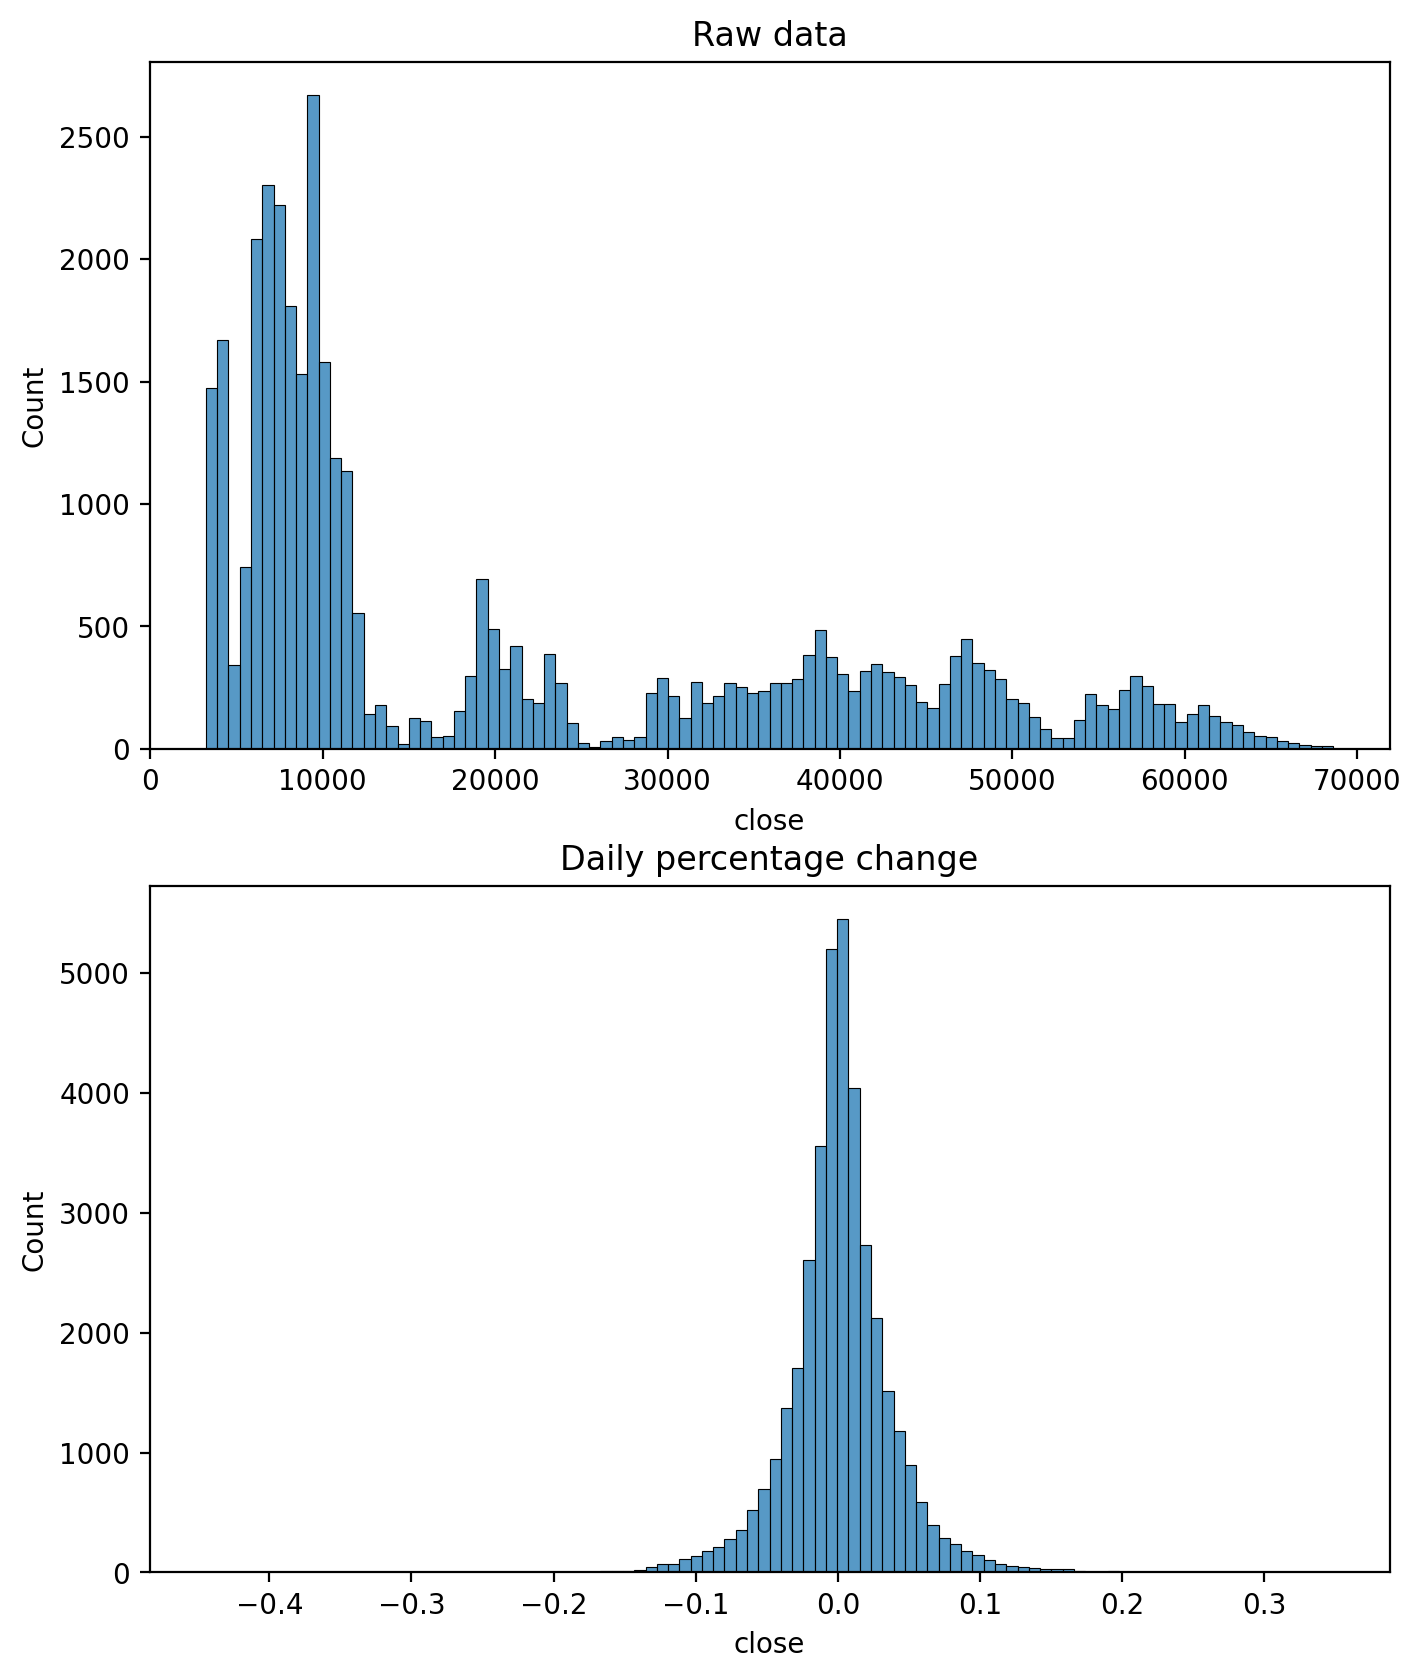

In [123]:
fig,ax = plt.subplots(2,figsize=(8,10),dpi=200)
sns.histplot(data.pct_change(24).dropna(), bins=100,ax=ax[1]) # Daily change
ax[1].set_title('Daily percentage change')
sns.histplot(data, bins=100,ax=ax[0])
ax[0].set_title('Raw data')

In [124]:
class WindowedTransformer(object):
    '''
    Create a parent object with the information required for 
    the transformation of the samples and targets.
    '''

    def __init__(self,window,split,
                    scaler_day,
                    ):
        '''
        Inputs:

          - window [int]: Window of samples passed to the model. 
                    Note that the colums are supposed to be filtered on the Main Generator. e.g. Data[-window:,:]
          - split [int]: Window of samples used as the target.
                    Note that the colums are supposed to be filtered on the Main Generator.
        '''
        # set windower parameters
        self.window = int(window)
        self.split = split
        self.scaler_day = scaler_day
        

class WinTargeter(WindowedTransformer):

    '''Make the specific tranformation to the samples to be used.
        Here we are going to add an extra option If we want a regression or a Classification problem. 
        Regresion answers the question: Which will be the price of the Bitcoin in 24 hours?
        Classification answers the question: Is the Bitcoin price going to be higher or lower than now in 24 hours?'''

    def __init__(self,window_jump,regression=True,
                **kargs):
        super().__init__(**kargs)
        self.regression = regression
        self.window_jump = window_jump

    def get_value(self,target):
        '''The values of the targets with percentage change.'''
        return pd.DataFrame(target).pct_change(self.scaler_day*self.window_jump).iloc[-self.split:].values.reshape((-1,))

    def get_categorical(self,x):
        '''The value rised of droped?'''
        return int(x > 0)

    def __call__(self,target):
        '''The call method allow data generator to perform the transformation'''
        if self.regression:
            return torch.tensor(pd.DataFrame(target).iloc[-self.split:].values.reshape(-1,1),
                            dtype=torch.float)[0,:1]
        return torch.tensor(self.get_categorical(self.get_value(target)))
      
    
class WinSampler(WindowedTransformer):

    '''Here we transform a 1D prices signal into a 3D representation.
    '''
  
    def __init__(self,mean=None,std=None,
                    minimum=None,maximum=None,
                    min_max=False,normalize=False,
                    **kargs):
        super().__init__(**kargs)

        '''
        mean, std [list]: Lists of values to apply the Zero mean normalization.
        minimum, maximum [list]: Lists of values to apply the min_max normalization.
        min_max, normalize [Boolean]: Which type of normalization applies?
        '''
        self.scaler = np.linspace(self.scaler_day//2,self.scaler_day*30,168,dtype='int64')

        self.normalize = normalize
        self.min_max = min_max
        if normalize:
            assert mean is not None and std is not None,'If "normalize" is True, mean and std of the correct shapes has to be passed'
            self._mean = mean
            self._std = std
        elif min_max:
            assert maximum is not None and minimum is not None,'If "max_min" is True, maximum and minimum of the correct shapes has to be passed'
            self.__max = maximum
            self.__min = minimum

    def scaled_cwt(self, sample):
        return cwt(sample,self.scaler, wavelet = 'morl')[0]
    
    def compute_pct(self,ema,sample,change):
        # alpha = lambda n: 2/(n+1)  
        return sample.pct_change(change).values[-self.window:,0]
    
    def perform_norm(self, sample, dim):
        if self.normalize:
            sample = (sample - self._mean[dim])/np.sqrt(self._std[dim])
        elif self.min_max:
            sample = (sample - self.__min[dim])/(self.__max[dim] - self.__min[dim])
        return sample

    def __call__(self,sample):
        '''The call method allow the used of the transformation on data generator.'''

        sample = pd.DataFrame(sample)
        sample = np.stack(
            [
            # Raw Data
            self.scaled_cwt(self.perform_norm(self.compute_pct(self.scaler_day,sample,self.scaler_day),0)), # Daily percentage change
            self.scaled_cwt(self.perform_norm(self.compute_pct(self.scaler_day,sample,self.scaler_day*7),1)), # Weekly percentage change
            self.scaled_cwt(self.perform_norm(self.compute_pct(self.scaler_day,sample,int(self.scaler_day*30.436875)),1)), # Monthly percentage change
            ],axis=0).astype(np.float32)
        
        return torch.tensor(sample).to(dtype=torch.float)



<font size="3"><font>
Now we are going to create the different datasets. Additionally, we will use the transform methods from PyTorch to help us modify our sample, the samples should have the same distributions and shapes as the inputs for which the model was trained. 

In [125]:
def visualize_sample(s):

    names = ['Daily EMA [Day%]','Daily EMA [Week%]','Daily EMA [Month%]',
            'Weel EMA [Week%]','Week EMA [Month%]',
            'Month EMA [Month%]']
    fig,axs = plt.subplots(2,2,figsize=(15,12))
    for n,i,ax in zip(names,s,axs.flat):
        ax.imshow(i.view(-1,224))
        ax.set_title(n)
    axs.flat[-1].imshow(s.permute(1,2,0))
    print('Mean:{}\nSTD:{}\nMax:{}\nMin:{}'.format(torch.mean(s,dim=(1,2)),
                                                  torch.std(s,dim=(1,2)),
                                                  torch.max(s),
                                                  torch.min(s),
                                                  ))
    plt.show()

/var/folders/x1/b34lt2w1783_jtyf06g7hv4c0000gp/T/ipykernel_1165/3452244547.py:40: UserWarning: "start_date" was updated from 2018-05-15 06:00:00 to 2018-07-15 03:00:00 due to warm up time
  warnings.warn(f'"start_date" was updated from {history.index[0]} to {start_date} due to warm up time')
/var/folders/x1/b34lt2w1783_jtyf06g7hv4c0000gp/T/ipykernel_1165/3452244547.py:45: UserWarning: "end_date" was updated from 2022-10-03 00:00:00 to 2022-10-02 00:00:00 due to window jump
  warnings.warn(f'"end_date" was updated from {history.index[-1]} to {end_date} due to window jump')



Tranin dataset:
	From 2018-07-15 03:00:00 to 2021-06-27 00:00:00.
	Length = 25870
	 Iterations = 102    
Development dataset:
	From 2021-06-27 01:00:00 to 2022-05-01 00:00:00.
	Length = 7392
	 Iterations = 29    
Test dataset:
	From 2022-05-01 01:00:00 to 2022-10-02 00:00:00.
	Length = 3696
	 Iterations = 15
Shape of each sample: torch.Size([3, 224, 224])
Shape of each target: torch.Size([])

Mean:tensor([0.5001, 0.4980, 0.4961])
STD:tensor([0.1465, 0.2032, 0.2152])
Max:0.9921568632125854
Min:0.0117647061124444


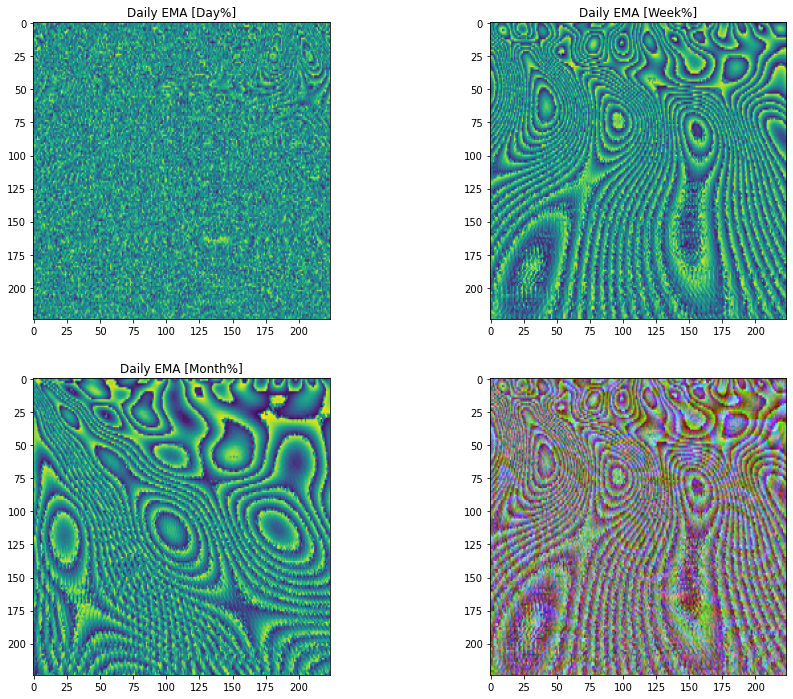

In [126]:
win_samp = WinSampler(window = int(WINDOW_SIZE*SCALER_DAY),
                    mean = np.array([0.00118178, 0.01023941, 0.05150491]), # Mean and std of the prices
                    std = np.array([0.02833833, 0.09771589,0.23481684]),
                    normalize = True,
                    split = 1,
                    scaler_day = SCALER_DAY
                    )
win_targeter = WinTargeter(window_jump=WINDOW_JUMP,regression=False, # To keep it simple lets do a Classification task
                    window = int(WINDOW_SIZE*SCALER_DAY),
                    split = TARGET,
                    scaler_day = SCALER_DAY)

preprocess = transforms.Compose([win_samp, 
                                transforms.Normalize(mean=[-0.00183406,  0.00116552, -0.005963],# Mean and Std of the CWT samples
                                                     std=[0.71697076, 1.88798626, 1.79590736]),

                                transforms.Normalize(mean=[0.485, 0.456, 0.406], # Set the mean and Std
                                                     std=[0.229, 0.224, 0.225]), # To the used by the pretrained model
                                                     
                                transforms.ToPILImage(),
                                transforms.Resize((256,256),interpolation=transforms.InterpolationMode.HAMMING),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                ])

dataset_generator = StoryTeller(get_btcusd_data(),
                            'BTCUSD',
                            'hour',
                            features = ['close'],
                            dim_target = ['close'],
                            window_jump=int(WINDOW_JUMP*SCALER_DAY),
                            warmup=int((WARMUP+WINDOW_SIZE)*SCALER_DAY),
                            transforms=preprocess,  
                            target_transforms=win_targeter)
total_loader = DataLoader(dataset_generator, batch_size=BATCH_SIZE,shuffle=True)


train_dataset = DataGenerator(dataset_generator,[0.,0.70],)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=False)

dev_dataset = DataGenerator(dataset_generator,[0.70,0.9],)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE,shuffle=False)

test_dataset = DataGenerator(dataset_generator,[0.9,1.],)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)

print('\nTranin dataset:\n\tFrom {} to {}.\n\tLength = {}\n\t Iterations = {}\
    \nDevelopment dataset:\n\tFrom {} to {}.\n\tLength = {}\n\t Iterations = {}\
    \nTest dataset:\n\tFrom {} to {}.\n\tLength = {}\n\t Iterations = {}'.format(train_dataset.get_date(0),train_dataset.get_date(-1),len(train_dataset),len(train_loader),
                                                                dev_dataset.get_date(0),dev_dataset.get_date(-1),len(dev_dataset),len(dev_loader),
                                                                test_dataset.get_date(0),test_dataset.get_date(-1),len(test_dataset),len(test_loader)))
print('Shape of each sample: {}\nShape of each target: {}\n'.format(train_dataset[0][0].shape,
                                                                  train_dataset[0][1].shape))
visualize_sample(train_dataset[0][0])                                                                

## Using pre-trained models

<font size="3"><font>
The research process helps set a good starting point, It could be the implementation of someone else to the same or related problem. In the world, there is a constant flow of information, new ideas, and improvements to existing ones, finding the good ones and staying updated with them is part of the job. Therefore, the revision of The State Of The Art is the starting line, whether for the feature extraction or the Neural network architecture selection. However, reproducing paper implementations could be difficult due to the many variables that could show up in two projects, and nothing guarantees that the training phase will go as expected. To overcome this process, a pre-build model is usually a good idea, e.g., [ModelZoo](https://modelzoo.co/) offers a good source of different models implemented in our favorite libraries. These pre-trained models come with weights adapted to a specific task and usually were trained with a considerable amount of data. 

These models could apply in the financial world, given that NLP and Speech recognition Systems usually require time memory and have a temporal dynamic behavior, the information that a model learns to extract from that data could be used in financial data as well. The idea behind this is Transfer learning, taking a model that already knows how to extract meaningful information (Initial layers) and adapting the classification phase to our task (final layers). A common approach is to let the final layers be updated and with a low learning rate (let's say learning capacity), although It depends on the amount of data available, the more data you have, the more a strong adaptation is likely to end up well.

As mentioned earlier, there are implementations dedicated to regression tests that could be more helpful for our project - I will let that for you to enjoy yourself -, for now, we will keep it simple and use a model of the [PyTorch repository](https://pytorch.org/hub/research-models). Therefore, the selected model was [MobilNetV2](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/), It is a model designed for [Computer Vision](https://en.wikipedia.org/wiki/Computer_vision) and more specifically, to optimize Its use in mobile devices where exist memory limitations, perfect for our problem case. Additionally, the use of Convolutional Neural Networks (CNN) may have similar results due to their location sensitivity, recall that our X-axis and Y-axis represent time and frequency, respectively. 

# Pre-trained model: MobilNetV2

<font size="3"><font>
First, we have to import the model with its weights, the weights are necessary because that's the result of the training process, If not we would use only the architecture. As you may see, the architecture is divided between "features" and "classifier", which means that the first part extracts the features from the image, and the second converts and returns a classification based on those features. The model is designed to take a 3x224x224 image (convention used by PyTorch) and classify it between 1000 options, we only have a binary classification problem so the first thing to change is the classification layers. However, the dataset that we have is not small nor big, so for the example, we will unfreeze some layers of the feature extraction and train them.


In [127]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

In [128]:
pretrained_model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
pretrained_model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

The following function prints which parameters are trainable in the model, parameters are updated when the "requires_grad" attribute is True. By default, all the parameters are trainable, to freeze them, we have to set as False the layers that we don't want to update. Note that in the initial layers, the CNN extract features like edges or colors while the last ones take discriminative parts of the image [[Zeiler](https://link.springer.com/chapter/10.1007/978-3-319-10590-1_53#auth-Matthew_D_-Zeiler) & [Fergus](https://link.springer.com/chapter/10.1007/978-3-319-10590-1_53#auth-Rob-Fergus)., 2013, [Visualizing and Understanding Convolutional Networks](https://link.springer.com/chapter/10.1007/978-3-319-10590-1_53)], the latter will be the ones that we want to adjust to our problem. It may be worth updating more layers since the pre-trained model problem greatly differs from ours, just be careful not to lose the useful features the model identifies.

In [129]:
for i, (name,param) in enumerate(pretrained_model.named_parameters()):
    print('{}:{}\n\tShape={}\n\tRequires gradient={}'.format(i,name,param.shape,param.requires_grad))

0:features.0.0.weight
	Shape=torch.Size([32, 3, 3, 3])
	Requires gradient=True
1:features.0.1.weight
	Shape=torch.Size([32])
	Requires gradient=True
2:features.0.1.bias
	Shape=torch.Size([32])
	Requires gradient=True
3:features.1.conv.0.0.weight
	Shape=torch.Size([32, 1, 3, 3])
	Requires gradient=True
4:features.1.conv.0.1.weight
	Shape=torch.Size([32])
	Requires gradient=True
5:features.1.conv.0.1.bias
	Shape=torch.Size([32])
	Requires gradient=True
6:features.1.conv.1.weight
	Shape=torch.Size([16, 32, 1, 1])
	Requires gradient=True
7:features.1.conv.2.weight
	Shape=torch.Size([16])
	Requires gradient=True
8:features.1.conv.2.bias
	Shape=torch.Size([16])
	Requires gradient=True
9:features.2.conv.0.0.weight
	Shape=torch.Size([96, 16, 1, 1])
	Requires gradient=True
10:features.2.conv.0.1.weight
	Shape=torch.Size([96])
	Requires gradient=True
11:features.2.conv.0.1.bias
	Shape=torch.Size([96])
	Requires gradient=True
12:features.2.conv.1.0.weight
	Shape=torch.Size([96, 1, 3, 3])
	Require

## Our PyTorch model

<font size="3"><font>
This model will take a pre-trained model, unfreeze some layers and attach it to the classification output we need.
We create an object to manage the model and another to manage the training functions.

In [130]:
# Define model
class NeuralNetwork(nn.Module): # In

##  NETWORK INITIALIZATION
    def __init__(self,init_chans,pretrained): #Inherit the nn.Module from PyTorch
        '''
        Inputs:
          - init_chans [int]: This parameter set an initial number of neurons. Specific for the application.
          - Pretrained [PyTorch model]: Pretrained model to attach.
        '''
        
        super(NeuralNetwork,self).__init__()

        # Network Initialization
        self.pretrained = pretrained
        self.init_chans = init_chans
        self.network_init(init_chans)

        for i, param in enumerate(list(self.parameters())):
            param.requires_grad = i >= 153
        
        print('Up to the 17 layer of the pretrained model where freezed. \n\
          Only the last Conv2dNormActivation layer and the Linear layers will be updated.')

    def network_init(self,init_chans):
        '''
        Init the layers desired. 
        This kind of function is specific to the application.

        Inputs:
            - init_chans [int]: number of neurons for the initial layer. 
        '''


        #----- Layer 0 ------#
        # Pre-trained model

        #----- Layer 1 ------#
        self.fc1 = nn.Linear(init_chans,2)

    def forward(self, x): # 
        '''
        The forward function should not be called directly, 
        under the hood PyTorch call much more functions before and after the forward method.

        The forward function computes output Tensors from input Tensors.
        This kind of function is specific for the application.
        
        Inputs:
          - x [tesnsor]: Input data for the model.
        Return:
          - out [tensor]: Computed output.
        '''
        #----- Layer 0 ------#
        out = self.pretrained(x)
        
        #----- Layer 1 ------#
        out = self.fc1(out)
        
        return out

In [131]:
class CoachTheNetwork(NeuralNetwork):
    
##  NETWORK INITIALIZATION
    def __init__(self,
                 n_epochs, 
                 optimizer,lr,loss_fn,
                 device=None,**kwargs):
        '''
        Inputs:
          - n_epochs [int]: Only used in the training loop (fit) method. Required for the verbose.
          
          - optimizer [torch.optim method]: Optimizer used during the training step.
          
          - lr [float]: Learning Rate to use in the optimizer.

          - loss_fn [torch.nn.<someLoss> method]: A Loss functions that allows PyTorch to track the gradients.
                            For custom Loss: https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html
          
          # For the model creation training_loader, validation_loader, and metrics are not mandatory parameters.
          # The fit method allows passing them for the first time, being train_loader the only one mandatory for the training process.
          - train_loader [torch.utils.data.DataLoader object]: Expect a DataLoader object or an iterator that return (sample,target) with
                        shape [B,] + [input_size]. B is the number of batches. 
          - validation_loader [torch.utils.data.DataLoader object]: Expect a DataLoader object or an iterator that return (sample,target) with
                        shape [B,] + [input_size]. B is the number of batches. 
          
          - device [str]: On which device store and run the internal tensors of the model. 
                        If None, the default would be 'cuda' in case It is available.
        '''

        super().__init__(**kwargs)
        

        # Store device to use
        if device is None:
            self.device = device = "cuda" if torch.cuda.is_available() else "cpu"
        else:
            self.device = device

        # Train parameters
        self.n_epochs = n_epochs
        self.loss_fn = loss_fn
        self.lr = lr
        self.optimizer = optimizer(self.parameters(),lr)


        # Set the object itself to device
        self.to(device=self.device)

##  RUNNING A STEP
    def run_step(self,sample,target):
        '''
        Compute the output with the call method of the model.
        
        Inputs:
          - sample [tensor]: Input data to compute an output.
          - target [tensor]: "True" value or desired target of our model.
        
        Returns:
          - loss [tensor]: computed loss on the step.
          - output [tensor]: Computed output of the model.
        '''
        # Transfer to device
        sample = sample.to(device=self.device)
        target = target.to(device=self.device)
        # Compute predictions
        output = self(sample)
        # Compute Loss
        return self.loss_fn(output,target),output.to(device=self.device)
    
    def train_step(self,sample,target):
        '''
        Compute a training step an update the gradients.

        Inputs:
          - sample [tensor]: Input data to compute an output.
          - target [tensor]: "True" value or desired target of our model.
        
        Returns:
          - loss [tensor]: computed loss on the step.
          - output [tensor]: Computed output of the model.
        '''
        # Get step loss
        loss, output = self.run_step(sample,target)
        # Update Gradients
        return self.update_grads(loss),output
        
    def update_grads(self,loss):
        '''Update the gradiente with computed loss'''
        # Update Gradients
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

##  VALIDATION METHODS: No gradients enviroment
    def validation_generator(self, validation_loader):
        '''
        Compute the output and loss on a DataLoader without updating the gradients.
        Note that it's designed for the validation DataLoader but could be use at
        any time the loss is required but updating the grads not.

        Inputs: 
          - validation_loader [torch.utils.data.DataLoader object]: Expect a DataLoader object or an iterator that return (sample,target) with
                        shape [B,] + [input_size]. B being number of batches. 
        Returns:
          Since It is a generator It will return one value at a time.

          - loss [tensor]: Accumulated computed loss.
        '''
        val_loss = 0.0

        # Turn of the computation of gradients
        with torch.no_grad():
          for sample, target in validation_loader:
              # With the no grad active this is only a validation step
              step_loss, output = self.run_step(sample,target)
              val_loss += step_loss

        return val_loss.item()

##  FIT METHODS
    def fit(self,train_loader,validation_loader=None,
            verbose=True):
      
        '''
        Method used for traning.

        Inputs: 
          - train_loader [torch.utils.data.DataLoader object]: Expect a DataLoader object or an iterator
                         that return (sample,target) with shape [B,] + [input_size]. B being number of batches.

          - validation_loader[torch.utils.data.DataLoader object]: Expect a DataLoader object or an iterator
                         that return (sample,target) with shape [B,] + [input_size]. B being number of batches.

          - verbose [Boolean]: If create the interactive prints.
        '''

        # Number of Iterations
        iterations_per_epoch = len(train_loader)

        if validation_loader is not None:
            iterations_per_val = len(validation_loader)

        # Init Traning
        for epoch in range(1,self.n_epochs+1):
            # Reset Losses
            loss_train = 0.0
            
            for idx, (sample, target) in enumerate(train_loader):
                # Inform the model that we are in training steps
                self.train()
                sample = sample.to(device=self.device)
                target = target.to(device=self.device)
                # Make a training step
                loss_step, output = self.train_step(sample,target)
                loss_train += loss_step #Accumulate the loss
                

                # Compute validation If passed, only in the last iteration of every epoch.
                if  idx == (iterations_per_epoch-1) and validation_loader is not None:
                    loss_val = self.validation_generator(validation_loader)
            
            if validation_loader is not None:
                print('Epoch {}: Training Loss = {},\tValidation Loss = {}'.format(epoch,
                                                        loss_train/iterations_per_epoch,
                                                        loss_val/iterations_per_val))
            else:
                print('Epoch {}: Training Loss = {}'.format(epoch,
                                                        loss_train/iterations_per_epoch))

# Test the model

In [132]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = CoachTheNetwork(n_epochs=10, 
                      optimizer=torch.optim.Adam,lr=1e-3,
                      loss_fn=nn.HuberLoss(),
                 init_chans=1000, pretrained=pretrained_model)
with torch.no_grad(): 
     y = model(dataset_generator[0][0].unsqueeze(0).to(device))
     y_true = dataset_generator[0][1].unsqueeze(0)
     prediction = nn.Softmax(dim=1)(y)
     print(f'Fresh model output {y}')
     print('Position cero for a drop and one for a rise. \nThe prediction probabilities are {}'.format(prediction))
     prediction = torch.max(prediction,dim=1)[1].numpy()
     if prediction:
          print('The model predicted a value rise.')
     else:
          print('The model predicted a value drop.')
     print('y={},\ty_true={}'.format(prediction,y_true))

Using cpu device
Up to the 17 layer of the pretrained model where freezed. 
          Only the last Conv2dNormActivation layer and the Linear layers will be updated.
Fresh model output tensor([[ 0.0873, -0.0085]])
Position cero for a drop and one for a rise. 
The prediction probabilities are tensor([[0.5239, 0.4761]])
The model predicted a value drop.
y=[0],	y_true=tensor([1])


In [133]:
model = CoachTheNetwork(n_epochs=5,
                        optimizer=torch.optim.Adam,lr=1e-5,
                        loss_fn=nn.CrossEntropyLoss(),
                        device=device,
                 init_chans=1000, pretrained=pretrained_model).to(device)

Up to the 17 layer of the pretrained model where freezed. 
          Only the last Conv2dNormActivation layer and the Linear layers will be updated.


In [ ]:
model.fit(train_loader=train_loader, validation_loader=dev_loader)

# Conclusions

<font size="3"><font>
Now that the basic functions to train the model have been implemented, we can start to experiment, you may try a regression model, or unfreezing more layers could be helpful, try different learning rates and optimization functions. Another interesting approach could be to make the size transformations that we made on the Custom Transformers through CNN layers. Some more research about the problem will help as well.

I hope this gives you a lead on how to start your project. For instance, in an environment like QC - free account at least - where the amount of memory at your disposal is limited, a very deep Neural Network would be impossible to use and even more impossible to train and adapt, so it is a good idea to take that into account when you are selecting a creating your model. If you would like to see how to implement this Neural Network on QC, let me know for another blog post.